# 1a. EEG Dataset Preprocessing

- 1a EEG Dataset Load & Preprocessing [Jump To](#run-1a-eeg-dataset-load--preprocessing)


## Ref Links

- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io
- MNE-Python: https://mne.tools/stable/index.html
- SpecParam: https://specparam-tools.github.io and https://github.com/fooof-tools

## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

EEG specific dependencies:
- mne = 1.9.0
- mne-icalabel = 0.7.0
- autoreject = 0.4.3
- specparam = 2.0.0rc3

# Imports & Functions

## Imports

In [1]:
# General imports
import os
import sys
import gc
import warnings

from datetime import datetime
from pprint import pprint
import time
import pickle
import random
from collections import Counter

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# MNE-Python
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
from autoreject import AutoReject
from autoreject import get_rejection_threshold

# # SpecParam
# from specparam import SpectralGroupModel
# from specparam.plts.spectra import plot_spectra
# # from specparam import __version__ as specparam_version
# # print('Current SpecParam version:', specparam_version)


## Raw EEG Load, Display, Save

In [2]:
# Function to plot EEG Time Series & Save to PDF
#

def plot_EEG_TD(eeg_FIF, channels, time_range_s=[], pdf_file = None):
    
    """
    EEG Time Domain Plot.

    Parameters
    ----------
    eeg_FIF : FIF
    channels : [str] eg ['P5', 'Pz']
    time_range_s : [nn,nn]
    """

    # Channels Limit
    max_plots = 5
    if len(channels) > max_plots:
        channels = channels[:max_plots]

    # Time Range
    sfreq = eeg_FIF.info['sfreq']
    if time_range_s:
        start = int(time_range_s[0] * sfreq)
        stop = int(time_range_s[1] * sfreq)
    else:
        start = 0
        stop = None

    # Get signal and times for the elected channel(s)
    # Handle Epoched data
    if eeg_FIF.__class__.__name__.startswith('Raw'):
        signal, times = eeg_FIF.get_data(picks=channels, 
                                        start=start, stop=stop,
                                        return_times=True)
    else:
        # warnings.warn("Epoched data detected: plotting may not be accurate for all types.", UserWarning)
        # return
        signal, times = eeg_FIF.get_data(picks=channels)
        signal = signal.mean(axis=0)
        times = eeg_FIF.times

    # plot and copy to pdf
    plt.figure(figsize=(12, 8))
    for i, ch_name in enumerate(channels):
        plt.plot(times, signal[i] * 1e6, label=ch_name, alpha=0.7, linewidth=0.6)
    plt.title('EEG Time Series - Channels: ' + ', '.join(channels))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.tight_layout()
    if pdf_file:
        pdf_file.savefig()
    plt.show()

In [3]:
# Function to save EEG data for a given subject
#

def save_EEG_for_subject(eeg_data, folder_path, subject_name, tag, epoched=False, format='fif', verbose=False):

    if epoched:
        subject_results_file = os.path.join(folder_path, f'{subject_name}_{tag}_epo.{format}')
    else:
        subject_results_file = os.path.join(folder_path, f'{subject_name}_{tag}_raw.{format}')

    if format == 'fif':
        eeg_data.save(subject_results_file, overwrite=False, verbose=verbose)
    elif format == 'set':
        mne.export.export_raw(subject_results_file, eeg_data, fmt='eeglab', overwrite=False, verbose=verbose)
    else:
        raise ValueError(f"Unsupported format: {format}")


## EEG Filtering

In [4]:
# Function to filter the raw EEG signal data
#

def perform_EEG_filtering(params, EEG_raw):
    """
    Preprocessing of the EEG raw data

    Parameters
    ----------
    params : dic
    EEG_raw : raw

    Returns
    -------
    EEG_clean : clean
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)
    if 'MONTAGE' not in globals():
        raise Exception("MONTAGE variable not found in globals.")

    EEG_filtered = EEG_raw.copy()

    # -----------------------------------------------------------------------
    # Bandpass filtering
    #
    EEG_filtered = EEG_filtered.filter(picks='eeg', 
                                       l_freq=params['band_pass_lf'], 
                                       h_freq=params['band_pass_hf'], 
                                       method=params['band_pass_method'], 
                                       phase='zero', 
                                       verbose=flag_verbose)

    # -----------------------------------------------------------------------
    # Montage Set
    # Attempt to use standard-1020 channels, but remove any channels not in it
    #
    std_1020_montage = mne.channels.make_standard_montage(MONTAGE)
    
    # Identify missing channels & drop them
    raw_set = set(EEG_raw.ch_names)
    montage_set = set(std_1020_montage.ch_names)
    missing_in_raw = montage_set - raw_set
    missing_in_montage = raw_set - montage_set  
    EEG_filtered.drop_channels(missing_in_montage)

    # Set to standard montage and plot
    EEG_filtered.set_montage(std_1020_montage)

    # -----------------------------------------------------------------------
    # Remove linear trends from each channel signal & average
    #
    if params['linear_detrend'] != 'none':
        EEG_filtered.apply_function(sci.signal.detrend, n_jobs=-1, 
                                    channel_wise=True, 
                                    type=params['linear_detrend'], 
                                    verbose=flag_verbose)

    # Execute average referencing
    EEG_filtered.set_eeg_reference(ref_channels=params['channel_referencing'], verbose=flag_verbose)

    if flag_verbose:
        # std_1020_montage.plot()
        print(f"Channels in montage but not in EEG_raw: {sorted(missing_in_raw)}")
        print(f"Channels in EEG_raw but not in montage: {sorted(missing_in_montage)}")
        print(f"Number of channels before: {len(EEG_raw.ch_names)} and after montage set: {len(EEG_filtered.ch_names)}")
        # fig = EEG_filtered.plot_sensors(show_names=True)
        # plt.show()

    return EEG_filtered


## Artefact Removal Functions

In [5]:
# Function to perform artifact removal using ICA etc
#

def perform_artefact_removal(params, EEG_raw):
    """
    Artefact removal on the EEG raw data, using ICA

    Parameters
    ----------
    params : dic
    EEG_raw : raw

    Returns
    -------
    results : pd series
    epochs_ar : fif
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_cleaned = EEG_raw.copy()
    quality_warning = False

    # -----------------------------------------------------------------------
    # Determine ICA components, label & identify for exclusion
    #

    # ICA & filter
    ica = ICA(n_components=len(EEG_cleaned.ch_names) - 1, 
              max_iter="auto", 
              method=params['ica_method'], 
              random_state=42, 
              fit_params=dict(extended=True))
    ica.fit(EEG_cleaned, verbose=flag_verbose)
    ic_labels = label_components(EEG_cleaned, ica, method='iclabel')
    labels = ic_labels["labels"]
    probs = ic_labels['y_pred_proba']

    # print(labels)
    # print(probs)
    # ica.plot_properties(EEG_raw, picks=[0, 12], verbose=False)
    # EEG_raw.load_data()
    # ica.plot_sources(EEG_raw, show_scrollbars=False, show=True)

    # More absolute approach to IC exclusion
    #
    # labels = ic_labels["labels"]
    # brain_components = [i for i, label in enumerate(labels) if label == "brain"]
    # other_components = [i for i, label in enumerate(labels) if label != "brain"]
    # filtered_ica = ica.apply(EEG_cleaned.copy(), exclude=np.unique(other_components), verbose=flag_verbose)

    # Exclude based on probabilities of label identification - Generous approach
    brain_components = []
    reject_components = []

    for idx, label in enumerate(labels):
        prob = probs[idx]
        # print(f'test: {idx} {label} {prob}')

        if label == 'brain' and prob > 0.5:
            brain_components.append(idx)
            # print('Brain')
        elif (label in ['muscle artifact', 'eye blink']) and prob > 0.9:
            reject_components.append(idx)
            # print('Reject muscle/eye')
        elif (label in ['line noise', 'channel noise']) and prob > 0.8:
            reject_components.append(idx)
            # print('Reject noise')
        elif label == 'other' and prob > 0.9:
            reject_components.append(idx)
            # print('Reject other')
        else:
            brain_components.append(idx)
            # print('Fall through')
    
    other_components = reject_components
    filtered_ica = ica.apply(EEG_cleaned.copy(), exclude=np.unique(other_components), verbose=flag_verbose)

    # Flag 'quality'
    ICA_rejection_level = len(other_components)/ica.n_components_
    if ICA_rejection_level >= params['ICA_rejection_threshold']:
        warnings.warn(f"High component rejection: {100 * ICA_rejection_level:.2f}% marked as non-brain.", UserWarning)
        quality_warning = True

    if flag_verbose:
        print('ICs Breakdown')
        print(f'Original Channels: {len(EEG_cleaned.ch_names)}. ICs: {ica.n_components_}')
        print(f'Brain Components: {len(brain_components)}, {100 * len(brain_components)/ica.n_components_:.2f}%')
        print(f'Other Components: {len(other_components)}, {100 * len(other_components)/ica.n_components_:.2f}%')
        print(f'List of Brain components: {brain_components}')

        # Details for non-brain ICs
        non_brain_labels = [label for label in labels if label != "brain"]
        label_counts = Counter(non_brain_labels)
        print("Non-brain IC counts:")
        for comp_type, count in label_counts.items():
            print(f"- {comp_type}: {count}")

        # Show the explained variance for top 5 components
        for component_idx in range(min(5, ica.n_components_)):
            component_variance = ica.get_explained_variance_ratio(EEG_cleaned, components=component_idx)
            print(f"Component {component_idx} contribution:", end=' ')
            for ch_type, variance in component_variance.items():
                print(f"  {ch_type}: {100 * variance:.2f}%")

        # ica.plot_overlay(EEG_cleaned, exclude=[0], picks="eeg")

    # -----------------------------------------------------------------------
    # Epoching & identify epochs for rejection
    #

    # Group the EEG signal into epochs and apply linear detrending
    epochs = mne.make_fixed_length_epochs(filtered_ica, duration=1, overlap=0, preload=True, verbose=flag_verbose)
    epochs.apply_function(sci.signal.detrend, type='linear', verbose=flag_verbose)

    # Identify unusual large amplitudes in each epoch, drop these
    reject_criteria = get_rejection_threshold(epochs, verbose=flag_verbose)
    epochs.drop_bad(reject=reject_criteria, verbose=False)

    # Instantiate AutoReject and clean individual segments
    epochs_ar, reject_log = ar_model.fit_transform(epochs, return_log=True)
    epochs_ar.pick(['eeg'])
    n_epochs_rejected = np.sum(reject_log.bad_epochs)
    epochs_rejection_level = n_epochs_rejected / len(epochs)
    
    if flag_verbose:
        print(f'Epochs rejected: {n_epochs_rejected} out of {len(epochs)}, {100 * epochs_rejection_level:.2f}%')
        # TODO: Are these plots really of much use?
        # Epochs plot rejection patterns
        reject_log.plot('horizontal')
        # Before and After
        epochs.average().plot() 
        epochs_ar.average().plot() 

        print('EEG Post Artifact Removal')
        print(epochs_ar)

    # -----------------------------------------------------------------------
    # Collate results
    #
    results = pd.Series({
        'EEG_preprocessing_quality_warning': quality_warning,
        'channel_count': len(EEG_raw.ch_names),
        'ICA_components_count': ica.n_components_,
        'ICA_rejection_level': ICA_rejection_level,
        'epochs_count': len(epochs),
        'epoch_rejection_level': epochs_rejection_level
        })
    
    return results, epochs_ar


# Run: 1a EEG Dataset Load & Preprocessing

In [6]:
# Run Details & Parameters
#

#---- Run Parameters --------------------------------
# Study Details
study_name = 'IOWA_Rest'

# Run Name & Test Mode
run_description = 'test_run'
test_mode = True

# Preprocessing Parameters
preprocess_params = {'band_pass_lf': 1, 'band_pass_hf': 100, 
                     'band_pass_method': 'iir', 'phase': 'zero',
                     'linear_detrend': 'linear',  # linear, none
                     'channel_referencing': 'average' 
                     }
artefact_params = {'ica_method': 'infomax', # infomax, none
                   'ICA_rejection_threshold': 0.8
                    }

MONTAGE = 'standard_1020'
#----------------------------------------------------

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# EEG Raw data
eeg_source_data_path = study_info['eeg_source_data_path']

# Setup the processing run and results folder & save params
current_date = datetime.now().strftime('%Y%m%d')
run_name = f'1a_EEG_Preprocessing_Run_{current_date}_{run_description}'
run_results_path = utils.extend_folder_path(study_info['eeg_processing_results_path'], run_name, exists_ok=False)

run_details = pd.Series({
    'study_name': study_name,
    'run_name': run_name,
    'preprocess_params': preprocess_params,
    'artefact_params': artefact_params,
})
run_details.to_pickle(run_results_path + '/run_details.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
    test_subjects = [0,5,101]
    test_channels = ['F5', 'C3', 'P3', 'F6', 'C6', 'P6']
else:
    VERBOSE = False
    test_subjects = []
    test_channels = []
    
del current_date, study_name, run_description, study_folder_path


EEG Preprocessing
- Study: IOWA_Rest ds004584-1.0.0
- Run: 1a_EEG_Preprocessing_Run_20250725_test_run
- Preprocessing Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': 'linear', 'channel_referencing': 'average'}
- Artefact Removal Params: {'ica_method': 'infomax', 'ICA_rejection_threshold': 0.8}

-----------------------------------------------------------------------------------------------
Subject: sub-001
---Get EEG Raw Data - FIF -----------------------------------------
Opening raw data file /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/Study_IOWA_Rest/0_EEG_Source_Data/sub-001_source_raw.fif...
    Range : 0 ... 140829 =      0.000 ...   281.658 secs
Ready.
Reading 0 ... 140829  =      0.000 ...   281.658 secs...
Description: None on None
<Raw | sub-001_source_raw.fif, 63 x 140830 (281.7 s), ~67.8 MiB, data loaded>
<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, 

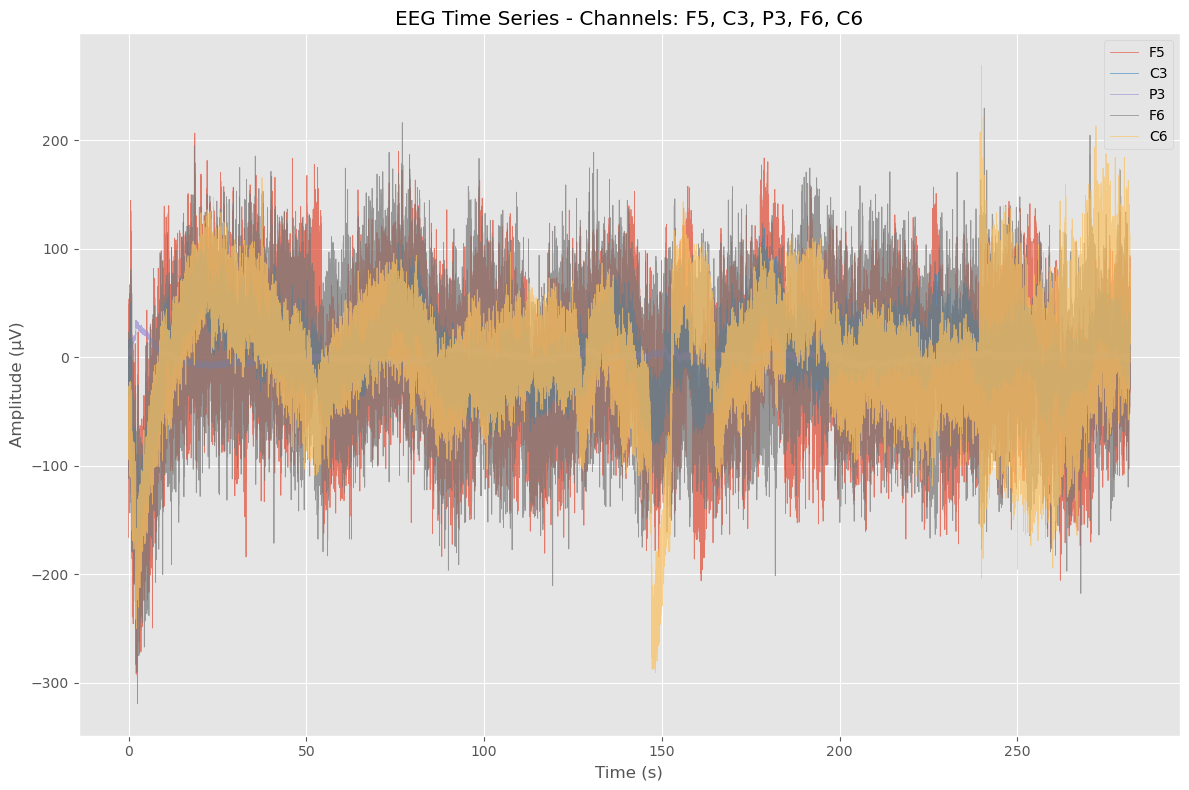

---Filtering & Referencing------------------------------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    1.7s finished


Channels in montage but not in EEG_raw: ['A1', 'A2', 'AF1', 'AF10', 'AF2', 'AF5', 'AF6', 'AF9', 'F10', 'F9', 'Fpz', 'Iz', 'M1', 'M2', 'O10', 'O9', 'P10', 'P9', 'PO1', 'PO10', 'PO2', 'PO5', 'PO6', 'PO9', 'Pz', 'T10', 'T3', 'T4', 'T5', 'T6', 'T9']
Channels in EEG_raw but not in montage: []
Number of channels before: 63 and after montage set: 63


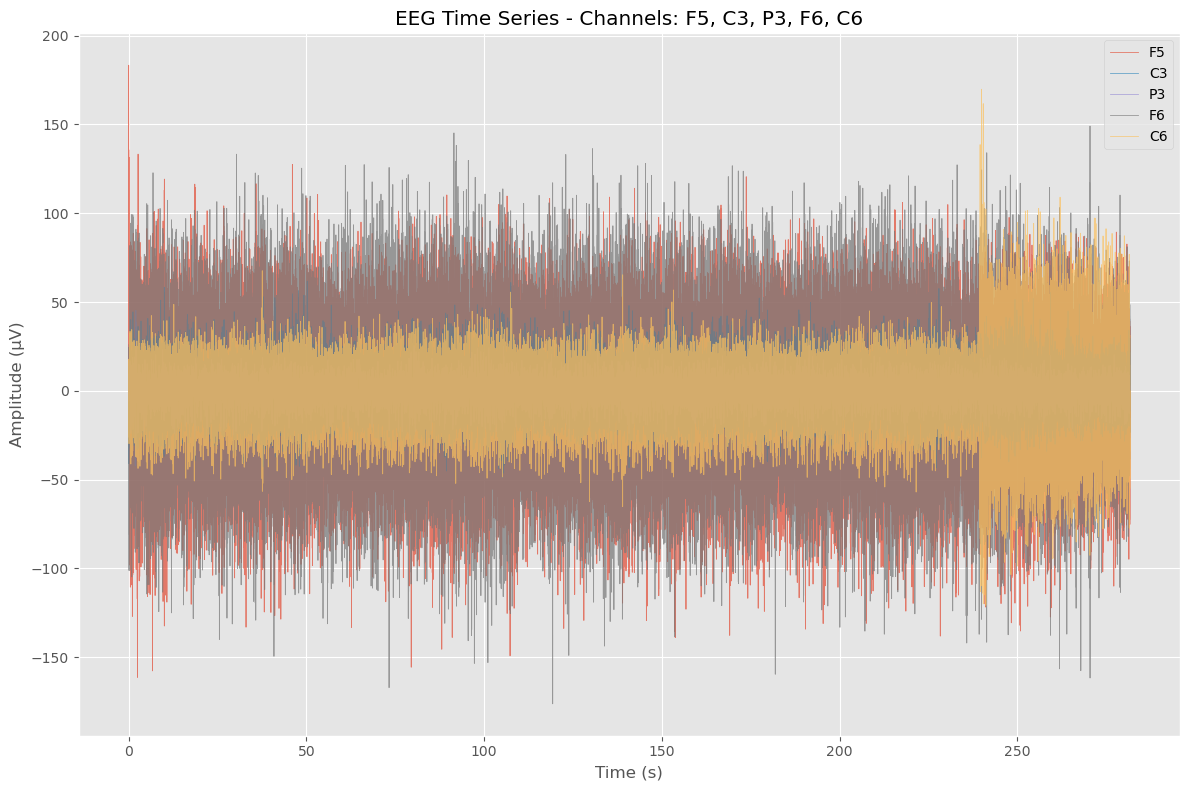

---Artefact Removal - ICA ------------------------------------------
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 62 components
Computing Extended Infomax ICA
Fitting ICA took 209.7s.
Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 29 ICA components
    Projecting back using 63 PCA components
ICs Breakdown
Original Channels: 63. ICs: 62
Brain Components: 33, 53.23%
Other Components: 29, 46.77%
List of Brain components: [0, 11, 12, 15, 17, 19, 21, 24, 28, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 45, 46, 47, 49, 50, 53, 54, 55, 57, 58, 59, 60, 61]
Non-brain IC counts:
- muscle artifact: 24
- eye blink: 2
- other: 27
- line noise: 3
- channel noise: 2
Component 0 contribution:   eeg: 13.32%
Component 1 contribution:   eeg: 12.40%
Component 2 contribution:   eeg: 11.63%
Component 3 contribution:   eeg: 9.29%
Component 4 contribution:   eeg: 8.91%
Not setting metadata
281 matching events f

  0%|          | Creating augmented epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/63 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=16


  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Epochs rejected: 0 out of 281, 0.00%


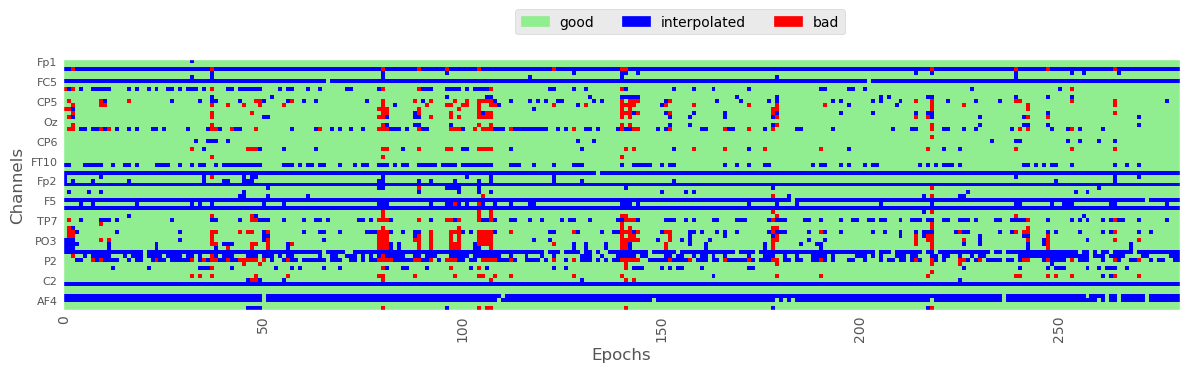

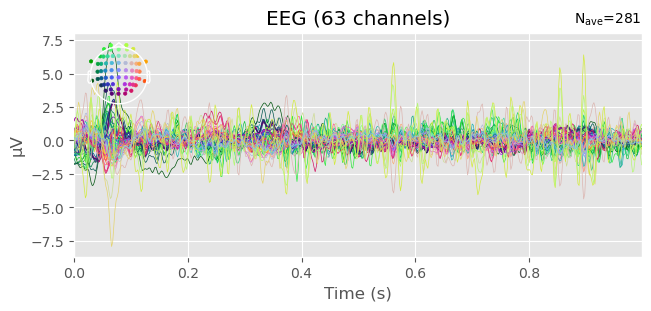

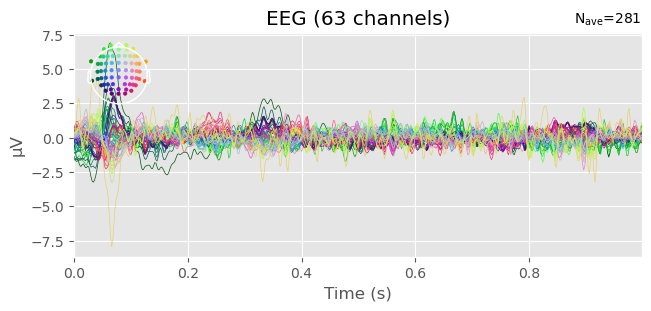

EEG Post Artifact Removal
<Epochs | 281 events (all good), 0 – 0.998 s (baseline off), ~67.6 MiB, data loaded,
 '1': 281>
Temp .... <Epochs | 281 events (all good), 0 – 0.998 s (baseline off), ~67.6 MiB, data loaded,
 '1': 281>, 
EEG_preprocessing_quality_warning       False
channel_count                              63
ICA_components_count                       62
ICA_rejection_level                  0.467742
epochs_count                              281
epoch_rejection_level                     0.0
dtype: object

-----------------------------------------------------------------------------------------------
Subject: sub-006
---Get EEG Raw Data - FIF -----------------------------------------
Opening raw data file /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/Study_IOWA_Rest/0_EEG_Source_Data/sub-006_source_raw.fif...
    Range : 0 ... 131029 =      0.000 ...   262.058 secs
Ready.
Reading 0 ... 131029  =      0.000 ...   262.058 secs...
Description: None on None
<Raw | sub-006_source_ra

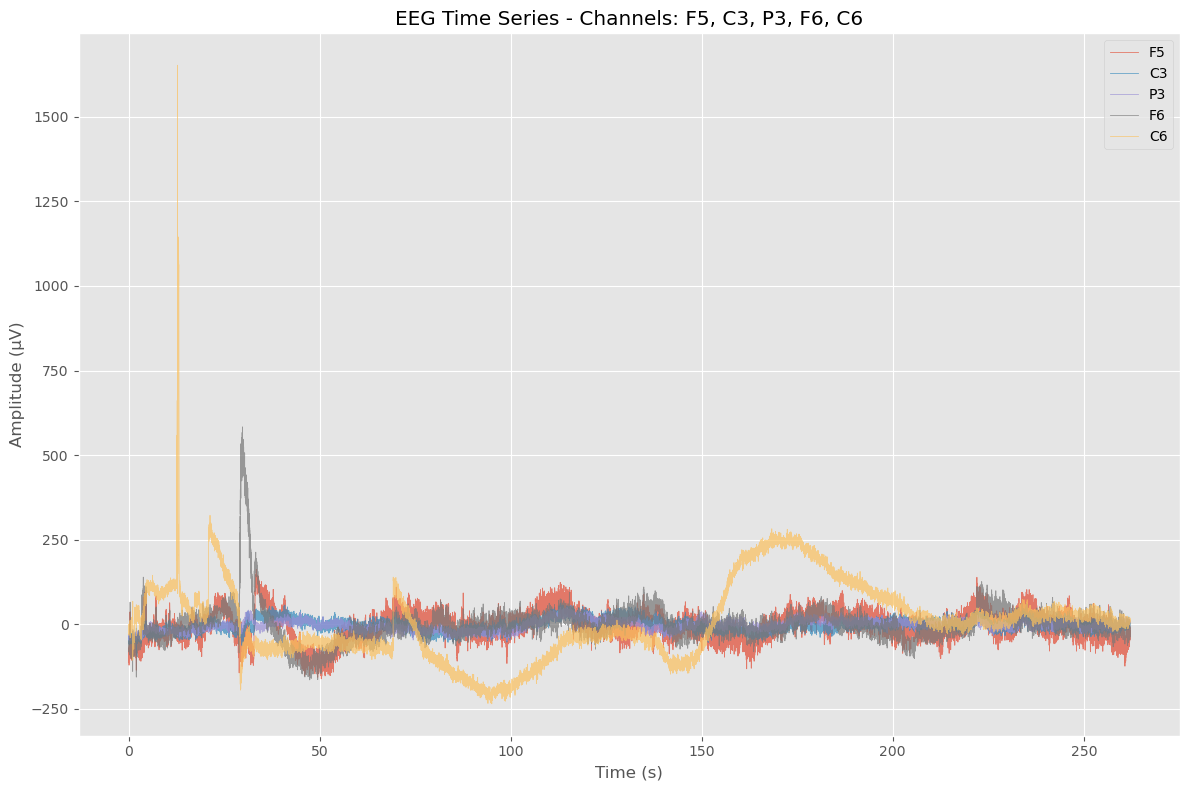

---Filtering & Referencing------------------------------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


EEG channel type selected for re-referencing
Applying average reference.


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    2.8s finished


Applying a custom ('EEG',) reference.
Channels in montage but not in EEG_raw: ['A1', 'A2', 'AF1', 'AF10', 'AF2', 'AF5', 'AF6', 'AF9', 'F10', 'F9', 'Fpz', 'Iz', 'M1', 'M2', 'O10', 'O9', 'P10', 'P9', 'PO1', 'PO10', 'PO2', 'PO5', 'PO6', 'PO9', 'Pz', 'T10', 'T3', 'T4', 'T5', 'T6', 'T9']
Channels in EEG_raw but not in montage: []
Number of channels before: 63 and after montage set: 63


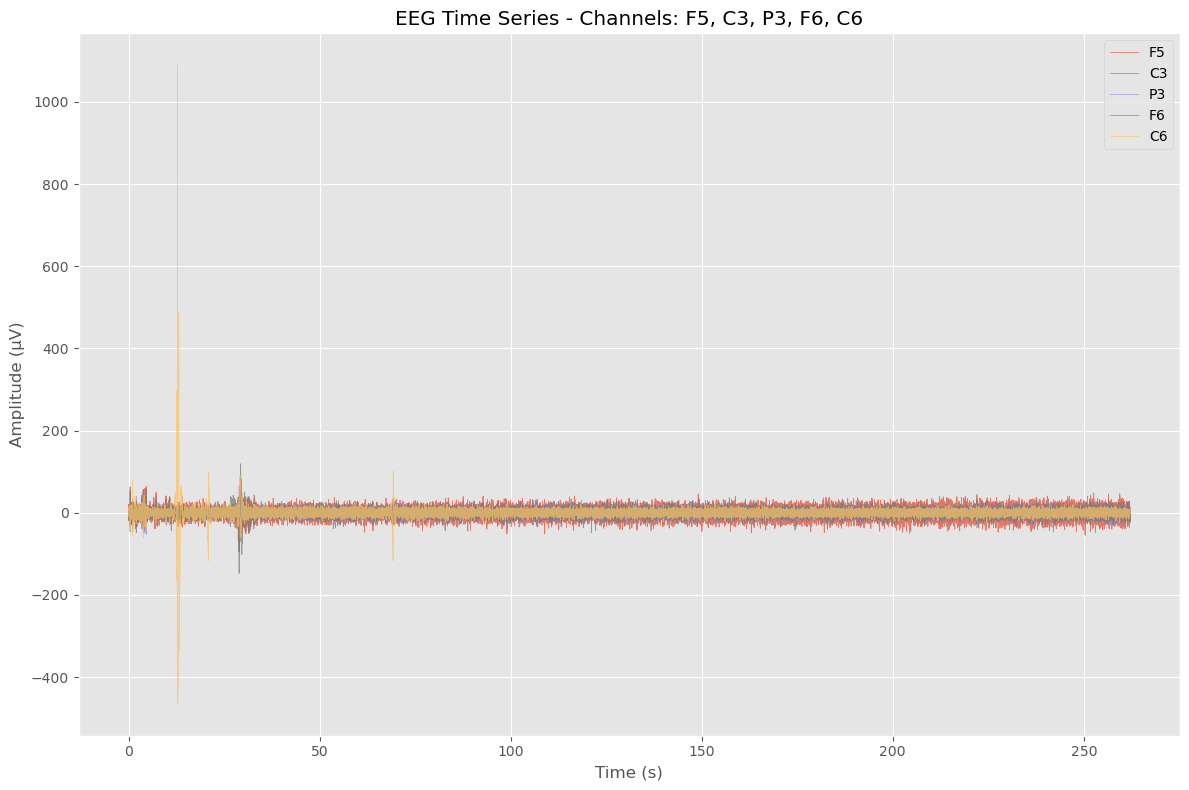

---Artefact Removal - ICA ------------------------------------------
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 62 components
Computing Extended Infomax ICA
Fitting ICA took 69.3s.
Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 11 ICA components
    Projecting back using 63 PCA components
ICs Breakdown
Original Channels: 63. ICs: 62
Brain Components: 51, 82.26%
Other Components: 11, 17.74%
List of Brain components: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 28, 29, 30, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61]
Non-brain IC counts:
- eye blink: 4
- other: 10
- line noise: 9
- channel noise: 2
- muscle artifact: 15
Component 0 contribution:   eeg: 22.31%
Component 1 contribution:   eeg: 19.52%
Component 2 contribution:   eeg: 6.82%
Component 3 contribution:   eeg: 6.59%
Component 4 contri

  0%|          | Creating augmented epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/63 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/257 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/257 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/257 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/257 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/257 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=16


  0%|          | Repairing epochs : 0/257 [00:00<?,       ?it/s]

Dropped 5 epochs: 1, 2, 12, 25, 26
Epochs rejected: 5 out of 257, 1.95%


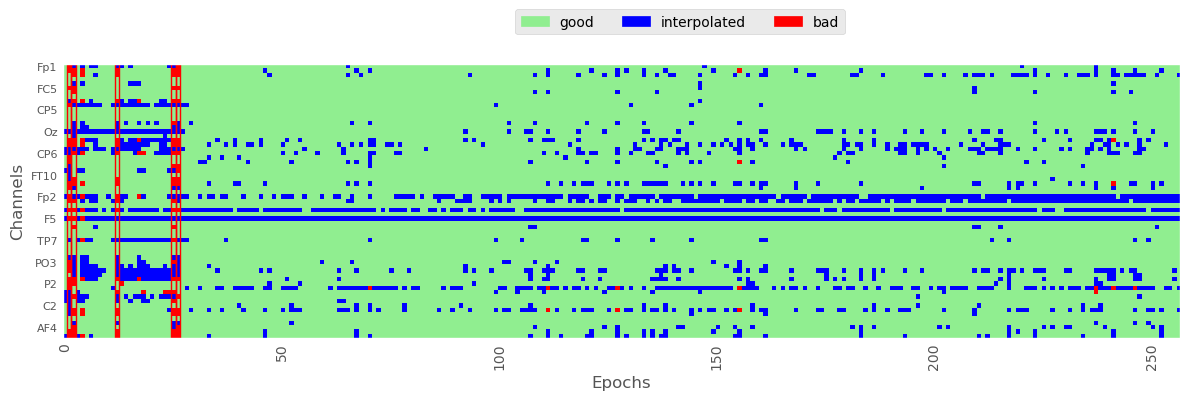

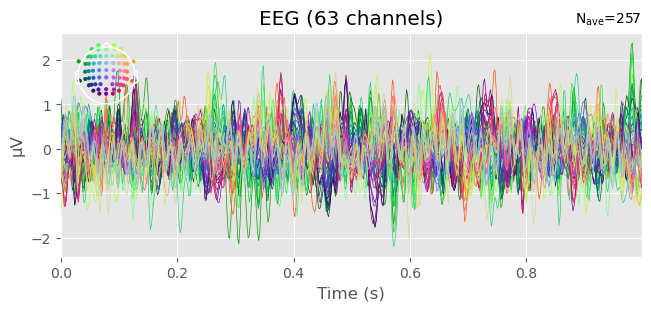

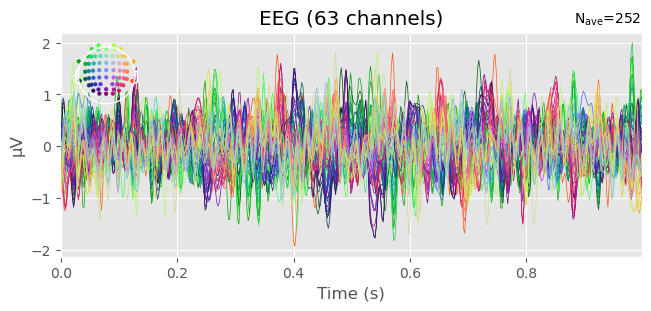

EEG Post Artifact Removal
<Epochs | 252 events (all good), 0 – 0.998 s (baseline off), ~60.6 MiB, data loaded,
 '1': 252>
Temp .... <Epochs | 252 events (all good), 0 – 0.998 s (baseline off), ~60.6 MiB, data loaded,
 '1': 252>, 
EEG_preprocessing_quality_warning       False
channel_count                              63
ICA_components_count                       62
ICA_rejection_level                  0.177419
epochs_count                              257
epoch_rejection_level                0.019455
dtype: object

-----------------------------------------------------------------------------------------------
Subject: sub-102
---Get EEG Raw Data - FIF -----------------------------------------
Opening raw data file /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/Study_IOWA_Rest/0_EEG_Source_Data/sub-102_source_raw.fif...
    Range : 0 ... 105429 =      0.000 ...   210.858 secs
Ready.
Reading 0 ... 105429  =      0.000 ...   210.858 secs...
Description: None on None
<Raw | sub-102_source_ra

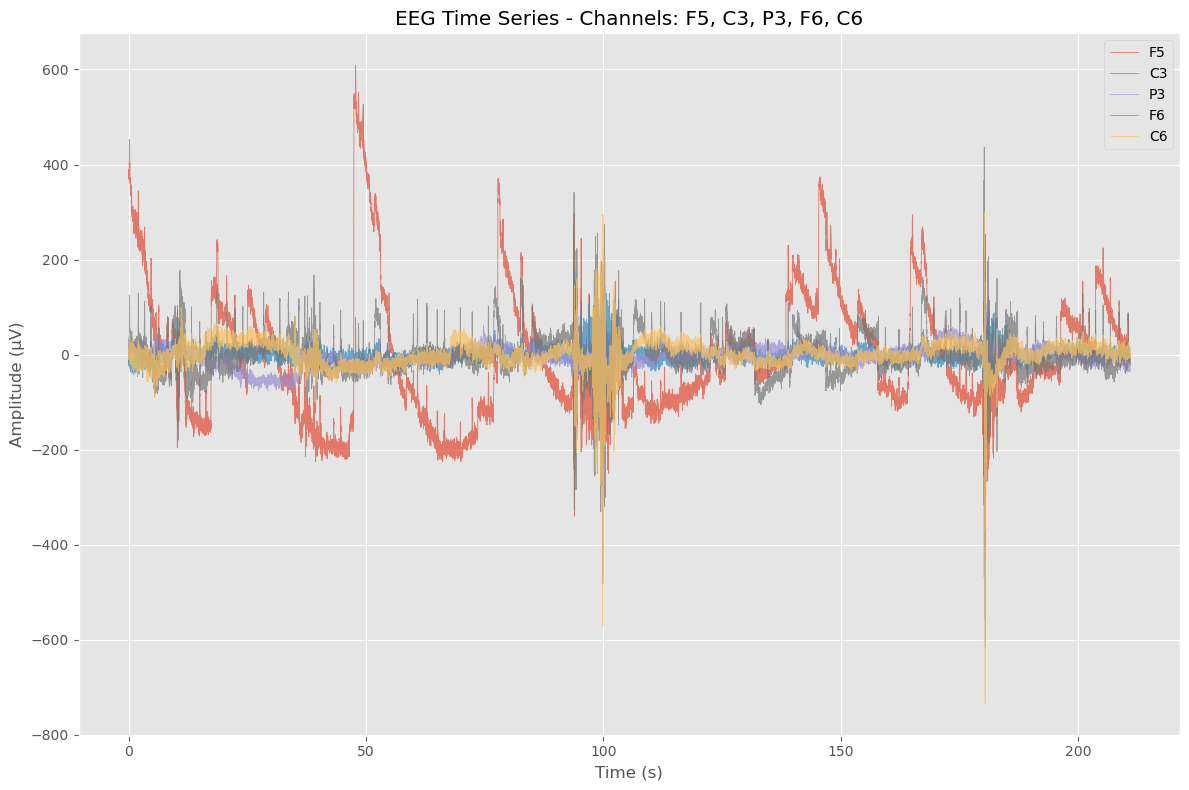

---Filtering & Referencing------------------------------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    3.0s finished


Channels in montage but not in EEG_raw: ['A1', 'A2', 'AF1', 'AF10', 'AF2', 'AF5', 'AF6', 'AF9', 'F10', 'F9', 'Fpz', 'Iz', 'M1', 'M2', 'O10', 'O9', 'P10', 'P9', 'PO1', 'PO10', 'PO2', 'PO5', 'PO6', 'PO9', 'Pz', 'T10', 'T3', 'T4', 'T5', 'T6', 'T9']
Channels in EEG_raw but not in montage: []
Number of channels before: 63 and after montage set: 63


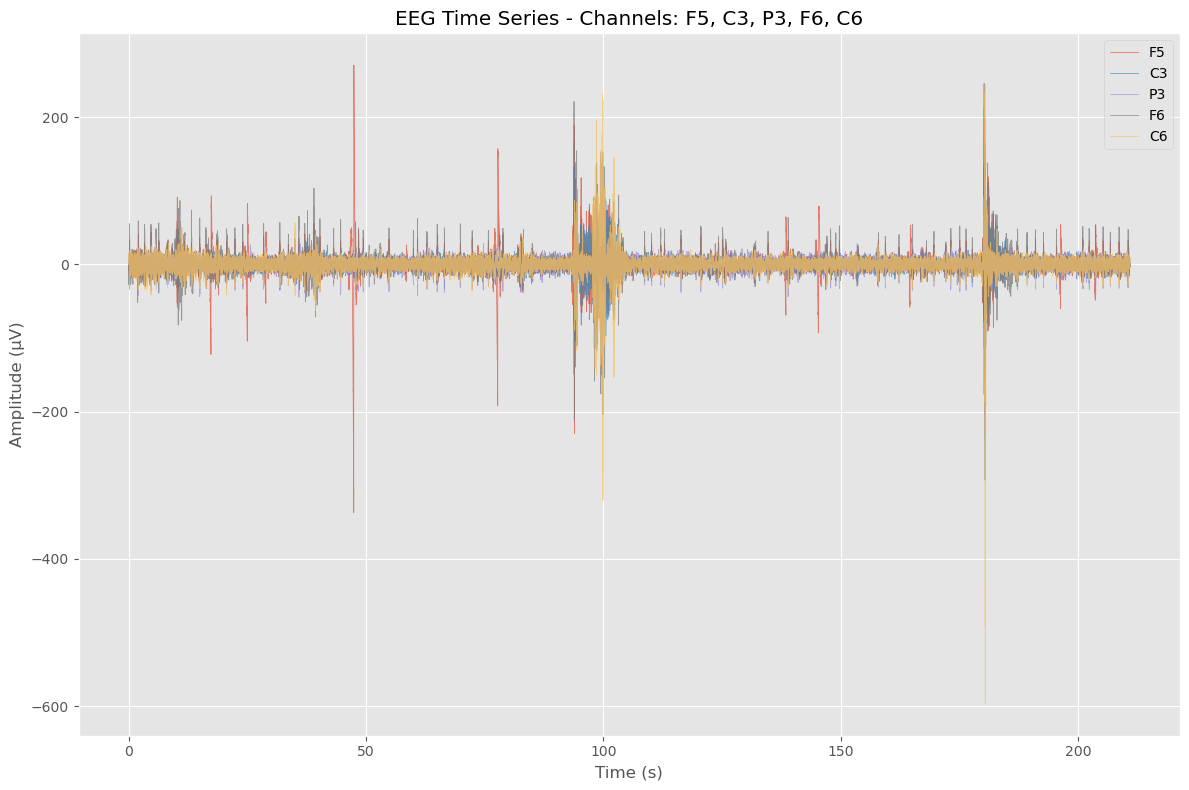

---Artefact Removal - ICA ------------------------------------------
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 62 components
Computing Extended Infomax ICA
Fitting ICA took 101.7s.
Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 16 ICA components
    Projecting back using 63 PCA components
ICs Breakdown
Original Channels: 63. ICs: 62
Brain Components: 46, 74.19%
Other Components: 16, 25.81%
List of Brain components: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 47, 48, 49, 52, 53, 57, 58, 59, 61]
Non-brain IC counts:
- eye blink: 2
- other: 8
- muscle artifact: 18
- line noise: 17
Component 0 contribution:   eeg: 53.37%
Component 1 contribution:   eeg: 7.84%
Component 2 contribution:   eeg: 4.09%
Component 3 contribution:   eeg: 3.42%
Component 4 contribution:   eeg: 2.96%
Not setting metada

  0%|          | Creating augmented epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/63 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=8


  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

Dropped 11 epochs: 5, 10, 11, 18, 39, 91, 93, 94, 95, 171, 172
Epochs rejected: 11 out of 200, 5.50%


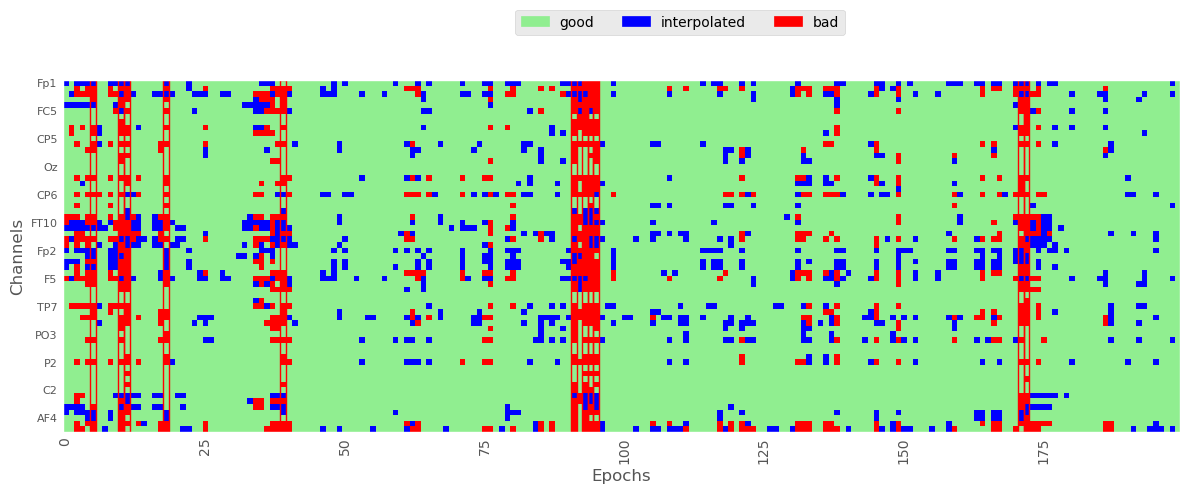

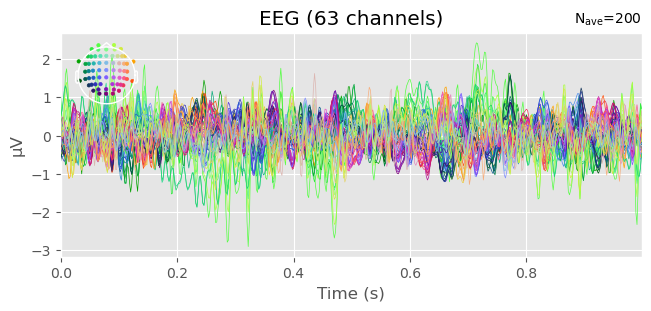

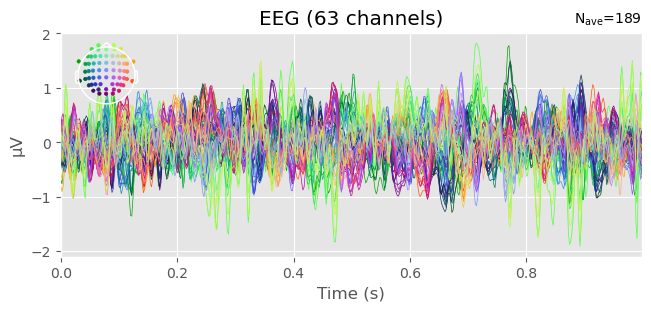

EEG Post Artifact Removal
<Epochs | 189 events (all good), 0 – 0.998 s (baseline off), ~45.5 MiB, data loaded,
 '1': 189>
Temp .... <Epochs | 189 events (all good), 0 – 0.998 s (baseline off), ~45.5 MiB, data loaded,
 '1': 189>, 
EEG_preprocessing_quality_warning       False
channel_count                              63
ICA_components_count                       62
ICA_rejection_level                  0.258065
epochs_count                              200
epoch_rejection_level                   0.055
dtype: object


In [7]:
# Run all the steps for EEG preprocessing
#

# Start Trace
summary = f'EEG Preprocessing'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- Run: {run_details['run_name']}"
summary = summary + f"\n- Preprocessing Params: {preprocess_params}"
summary = summary + f"\n- Artefact Removal Params: {artefact_params}"
print(summary)

# Initialize AutoReject
# TODO: Which initiailisation to use?
ar_model = AutoReject(cv=3, n_interpolate=[1, 4, 8, 16], 
                      consensus=[0.5, 1], 
                      thresh_method='bayesian_optimization',
                      random_state=42, n_jobs=-1, verbose=VERBOSE)
# ar_model = AutoReject(n_interpolate=[1, 2, 4], random_state=42, n_jobs=-1, verbose=VERBOSE)

# Loop through all selected subjects in the study
for idx, subject in study_subjects_df.iterrows():

    # Just sample a subset of subjects when in test mode
    if test_mode and idx not in test_subjects:
        continue

    subject_id = subject['subject_id']
    print('\n-----------------------------------------------------------------------------------------------')
    print(f'Subject: {subject_id}')

    # 1. EEG Raw Dataset Load
    #
    print('---Get EEG Raw Data - FIF -----------------------------------------')
    source_file_path = utils.get_file_path(eeg_source_data_path, f"{subject_id}_source_raw.fif")
    EEG_raw = mne.io.read_raw_fif(source_file_path, preload=True, verbose=VERBOSE)

    if VERBOSE:
        print(f"Description: {EEG_raw.info['description']} on {EEG_raw.info['meas_date']}")
        print(EEG_raw)
        print(EEG_raw.info)
        plot_EEG_TD(EEG_raw, test_channels)
    
    # 2. EEG Filtering & Referencing
    #
    print('---Filtering & Referencing------------------------------------------')
    EEG_filtered = perform_EEG_filtering(preprocess_params, EEG_raw)

    save_folder_path = utils.extend_folder_path(run_results_path, 'Cleaned_files')
    save_EEG_for_subject(EEG_filtered, save_folder_path, subject_id, tag='filtered')

    if VERBOSE:
        plot_EEG_TD(EEG_filtered, test_channels)

    # 3. Artefact Removal with ICA etc
    #
    print('---Artefact Removal - ICA ------------------------------------------')
    artefact_results, EEG_cleaned = perform_artefact_removal(artefact_params, EEG_filtered)

    # save_folder_path = utils.extend_folder_path(run_results_path, 'EEG_2_cleaned_files')
    save_EEG_for_subject(EEG_cleaned, save_folder_path, subject_id, tag='preprocessed', epoched=True)
    artefact_results.to_pickle(save_folder_path + f'/{subject_id}_preprocessing_results.pkl', compression='zip')

    if VERBOSE:
        # plot_EEG_TD(EEG_cleaned, test_channels)
        print(f'Temp .... {EEG_cleaned}, \n{artefact_results}')

